# Microsoft Stock Price Prediction

In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset , DataLoader
import torchmetrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv(r'D:\Data_projects\Raw_data\Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


The task is to predict one day's close price after sequence of days ( many-to-one ) 

In [63]:
# define data
df = df[['Date','Close']]
df.iloc[[0,-1] , :] # 6 years
df = df['Close']

Creating sequences and spliting ( train-test )

In [64]:
# --- Normalization is CRUCIAL for LSTMs ---
# We scale data to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
# Scaler expects a 2D array, so we reshape
scaled_data = scaler.fit_transform(df.to_numpy().reshape(-1, 1))
# Squeeze it back to a 1D array for sequence creation
scaled_data = scaled_data.flatten()

# This is our "sliding window" function from before
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        # Input: a window of 'sequence_length'
        window = data[i:(i + sequence_length)]
        X.append(window)
        # Target: the single value immediately after the window
        target = data[i + sequence_length]
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape for LSTM: (num_samples, seq_len, num_features)
    X = X.reshape(X.shape[0], sequence_length, 1)
    # Reshape target: (num_samples, 1)
    y = y.reshape(-1, 1)
    
    return X, y


sequence_length = int(len(df)/(6*12)) # sequence_length of one month
X, y = create_sequences(scaled_data, sequence_length) 

split_index = int(len(X) * 0.8) # training -> first 80% duration , testing -> last 20% .. splitting must be by time not random

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

In [65]:
X_train.shape

(1192, 20, 1)

In [66]:
# making torch datasets
dataset_train = TensorDataset(
torch.from_numpy(X_train).float(),
torch.from_numpy(y_train).float(),
)
dataset_test = TensorDataset(
torch.from_numpy(X_test).float(),
torch.from_numpy(y_test).float(),
)
train_loader = DataLoader(dataset_train, batch_size=32, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=32, drop_last=True)

Using enhanced RNN versions ( LSTM & GRU ) to maintain long-term memory

In [67]:
# defining the two models
class net1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        c0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
################################
class net2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            )
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [68]:
for seqs, labels in test_loader:
    print(seqs.shape)

torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])
torch.Size([32, 20, 1])


In [75]:
# # train LSTM
# model1 = net1(input_size=1)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
# model1.parameters(), lr=0.001
# )
# for epoch in range(50):
#     for seqs, labels in train_loader:
#         outputs = model1(seqs)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# # evaluate LSTM
# mse = torchmetrics.MeanSquaredError()
# model1.eval()
# with torch.no_grad():
#     for seqs, labels in test_loader:
#         outputs = model1(seqs)
#         mse(outputs, labels)
# print(f"Test MSE: {mse.compute()}")

Test MSE: 0.01838940568268299


In [90]:
# train GRU
model2 = net2(input_size=1)
criterion = nn.MSELoss()
optimizer2 = torch.optim.Adam(
model2.parameters(), lr=0.001
)
for epoch in range(50):
    for seqs, labels in train_loader:
        outputs2 = model2(seqs)
        loss2 = criterion(outputs2, labels)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
# evaluate GRU
mse2 = torchmetrics.MeanSquaredError()
model2.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        outputs2 = model2(seqs)
        mse2(outputs2, labels)
print(f"Test MSE: {mse2.compute()}")

Test MSE: 0.0031130658462643623


Saved prediction plot to 'prediction_plot(Train Set).png'
Saved prediction plot to 'prediction_plot(Test Set).png'


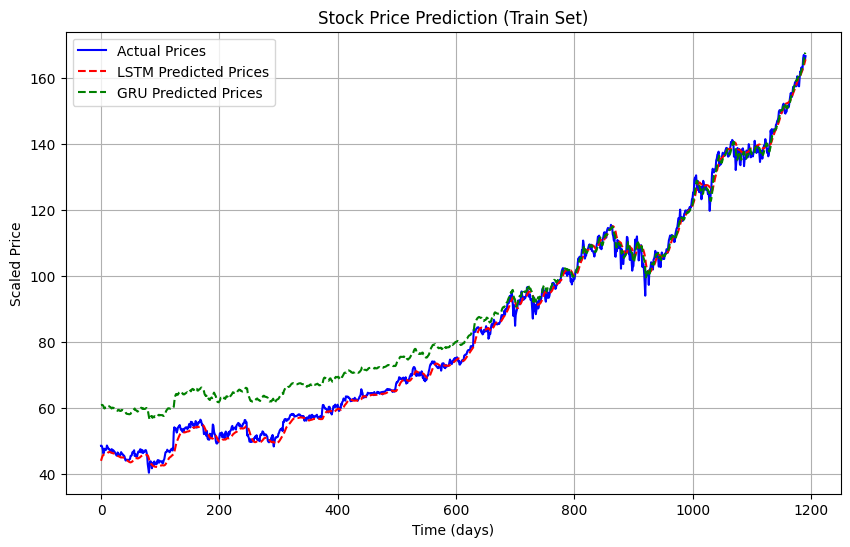

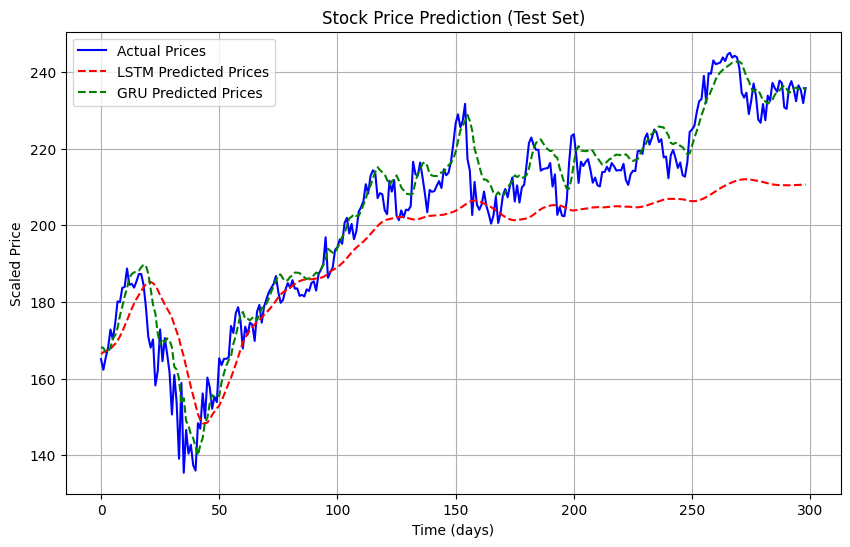

In [89]:
# Plotting the results for the  models

# Make predictions on the train set
model1.eval()
model2.eval()
with torch.no_grad():
    LSTM_predictions = model1(torch.from_numpy(X_train).float())
    GRU_predictions = model2(torch.from_numpy(X_train).float())

# "un-normalize" the data to see the real values
LSTM_predicted_prices = scaler.inverse_transform(LSTM_predictions.numpy())
GRU_predicted_prices = scaler.inverse_transform(GRU_predictions.numpy())
actual_prices = scaler.inverse_transform(torch.from_numpy(y_train).float().numpy())

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(LSTM_predicted_prices, label='LSTM Predicted Prices', color='red', linestyle='--')
plt.plot(GRU_predicted_prices, label='GRU Predicted Prices', color='green', linestyle='--')
plt.title('Stock Price Prediction (Train Set)')
plt.xlabel('Time (days)')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid()
plt.savefig('prediction_plot(Train Set).png')
print("Saved prediction plot to 'prediction_plot(Train Set).png'")

##############################################################

# Make predictions on the test set
model1.eval()
model2.eval()
with torch.no_grad():
    LSTM_predictions = model1(torch.from_numpy(X_test).float())
    GRU_predictions = model2(torch.from_numpy(X_test).float())

# "un-normalize" the data to see the real values
LSTM_predicted_prices = scaler.inverse_transform(LSTM_predictions.numpy())
GRU_predicted_prices = scaler.inverse_transform(GRU_predictions.numpy())
actual_prices = scaler.inverse_transform(torch.from_numpy(y_test).float().numpy())

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(LSTM_predicted_prices, label='LSTM Predicted Prices', color='red', linestyle='--')
plt.plot(GRU_predicted_prices, label='GRU Predicted Prices', color='green', linestyle='--')
plt.title('Stock Price Prediction (Test Set)')
plt.xlabel('Time (days)')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid()
plt.savefig('prediction_plot(Test Set).png')
print("Saved prediction plot to 'prediction_plot(Test Set).png'")